In [413]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import random
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import pickle
pd.set_option('display.max_columns', 100)  # or 1000
pd.set_option('display.max_rows', 100)  # or 1000
import shap
import time
from numpy import concatenate
Scaler = MinMaxScaler()

# Load training dataset

In [469]:
os.chdir('..')
os.getcwd()

'D:\\PDF_Uppsala\\7-Python code of ML algorithm\\GitHub\\Algal-bloom-prediction-machine-learning'

In [470]:
# Load training dataset
os.chdir('Trainning data')
file_name = input('file name of observation dataset:')
all_df = pd.read_csv(file_name,sep = ',',parse_dates = ['Date'])

file name of observation dataset:ME_Observation_df_modified.csv


In [472]:
# Specify the training year
n_trainingyr = int(input('Number of training years:'))
year = []
for i in range(n_trainingyr):
    y=int(input('Year:'))
    year.append(y)
# Lake Erken: [2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016] 

Number of training years:9
Year:1999
Year:2000
Year:2001
Year:2005
Year:2006
Year:2007
Year:2008
Year:2009
Year:2010


# GBR model

In [419]:
# Load testing dataset(Daily data)
def read_daily_test_df(test_time,features,file): # test_time = pd.Timestamp(yyyy,mm,dd)
    Lake_HydMet = pd.read_csv(file,header = 0,parse_dates = ['Date'])
    Lake_HydMet = Lake_HydMet[Lake_HydMet['Date']>=test_time[0]]
    return Lake_HydMet

In [420]:
def training_cv(df,features,nutrient,year):
    df['YY'] = df['Date'].apply(lambda d:d.year)
    df = df[df['YY'].isin(year)]
    X_train = df[features]
    y_train = df[nutrient].values

    GBR = GradientBoostingRegressor(random_state=101)
    n_estimators = [int(x) for x in np.arange(40,140,20)]
    max_depth=[int(x) for x in np.arange(5,10,1)]
    learning_rate = [x for x in [0.01,0.1,1]]
    subsample = [x for x in [0.7,0.8,0.9,1]]
    param_grid = {'n_estimators': n_estimators,
                  'max_depth': max_depth,
                  'learning_rate':learning_rate,
                  'subsample':subsample}
    GBR_rs = RandomizedSearchCV(estimator = GBR,param_distributions = param_grid,n_iter = 30,cv = 5,verbose = 0)
    GBR_rs.fit(X_train,y_train)
    #print(GBR_rs.best_params_)
    GBR.set_params(**GBR_rs.best_params_,random_state=101).fit(X_train,y_train)
    rmse = -cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'neg_root_mean_squared_error')
    r2 = cross_val_score(GBR, X_train, y_train, cv=5,scoring = 'r2')
    print('Training dataset evaluation:')
    print("RMSE %.2f (+/- %.2f)" % (rmse.mean(), rmse.std()))
    print("R2 %.2f (+/- %0.2f)" % (r2.mean(), r2.std()))
    pickle.dump(GBR, open("GBR."+nutrient.split('(')[0]+".dat", "wb"))

In [421]:
def predict(Lake_Nut,df,features,nutrient,test_time,ylim):
    #load the target GBR model
    GBR = pickle.load(open("GBR."+nutrient.split('(')[0]+".dat", "rb"))
    #predict yhat using test_X
    Lake_Nut[nutrient] =GBR.predict(Lake_Nut[features])
    nutrient_compare = Lake_Nut[['Date',nutrient]].merge(df[['Date',nutrient]],
                                                          how = 'inner',on = 'Date')
    nutrient_compare.columns = ['Date','Prediction','True']
    Date = pd.DataFrame(pd.date_range(start = test_time[0],
                                  end = test_time[1]),
                    columns = ['Date'])
    Lake_Nut_gap = Date.merge(Lake_Nut,how = 'left',on = 'Date')
    #nutrient_compare['Prediction_7d'] = Erken_Nut[nutrient]

    RMSE = mean_squared_error(nutrient_compare['True'],nutrient_compare['Prediction'],squared = False)
    #plot time-series comparison
    f2,ax2 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    Lake_Nut_gap.plot(x = 'Date',y =nutrient,c = 'b',ax = ax2[0],label = 'Predicted '+nutrient)
    Lake_Nut[nutrient] = Lake_Nut[nutrient].rolling(7,min_periods = 1).mean() # take the 7-day moving mean
    Lake_Nut_gap[nutrient] = Lake_Nut_gap[nutrient].rolling(7,min_periods = 1).mean()
    Lake_Nut_gap.plot(x = 'Date',y =nutrient,c = 'k',ax = ax2[0],label = 'Predicted 7d-averaged '+nutrient)
    df[['Date',nutrient]].plot(x = 'Date',y =nutrient,style = 'ro',ms = 7,alpha = 0.7,ax = ax2[0],label = 'Observation')
    ax2[0].text(0.2, 0.8, 'RMSE:{}'.format(round(RMSE,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[0].transAxes,fontsize='x-large')
    ax2[0].set_xlim((test_time[0],test_time[1]))
    ax2[0].set_ylim(ylim)
    
    R2 = r2_score(nutrient_compare['True'],nutrient_compare['Prediction'])
    #plot scatter plot
    ax2[1].scatter(nutrient_compare['True'],nutrient_compare['Prediction'],s = 20,c = 'blue')
    ax2[1].plot(nutrient_compare['True'],nutrient_compare['True'],lw  =1.5,color = 'black')    
    ax2[1].set_xlabel('True value')
    ax2[1].set_ylabel('Prediction')
    ax2[1].text(0.5, 0.8, 'R2:{}'.format(round(R2,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax2[1].transAxes,fontsize='x-large')
    
    return Lake_Nut,f2

In [473]:
# Choose the training features for daily nutrients prediction
n_features = int(input('Number of features:'))
features = []
for i in range(n_features):
    f = input('feature name:')
    features.append(f)
#Lake Erken: ['Date','month','U','SST','AirT','delT','Humidity','CC','swr(w/m2)','Prec(mm/d)','inflow(m3/s)',
#           'Ice_d','days from iceoff','MLD','thermD','W']
test_time = [pd.Timestamp(int(input('Test start in year:')),int(input('Test start in month:')),int(input('Test start on day:'))),
             pd.Timestamp(int(input('Test end in year:')),int(input('Test end in month:')),int(input('Test end in day:')))]
file = input('Name of daily observation datasets:')

Number of features:10
feature name:U
feature name:AirT
feature name:delT
feature name:inflow
feature name:outflow
feature name:swr
feature name:W
feature name:MLD
feature name:Ice_d
feature name:days_from_iceoff
Test start in year:2011
Test start in month:1
Test start on day:1
Test end in year:2016
Test end in month:1
Test end in day:1
Name of daily observation datasets:ME_Daily_Observation_df_modified.csv


In [474]:
testing_daily_df = read_daily_test_df(test_time,features,file)

<AxesSubplot:>

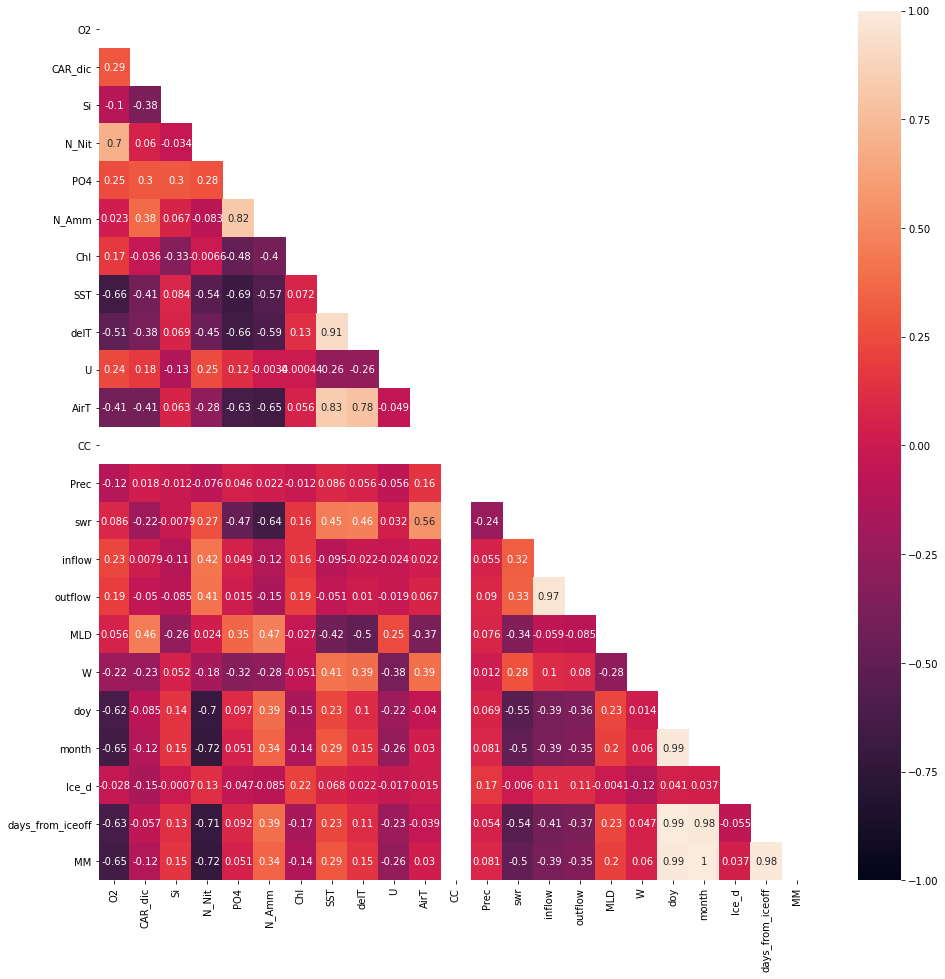

In [424]:
# Visualization of the correlations between features 
f,ax = plt.subplots(figsize = (16,16))
matrix = np.triu(all_df.corr())
sns.heatmap(all_df.corr(),vmin = -1, vmax = 1,annot = True,mask = matrix)

Target variable:O2
Training dataset evaluation:
RMSE 35.15 (+/- 10.08)
R2 0.71 (+/- 0.13)
Name of figure:ME_GBR_O2


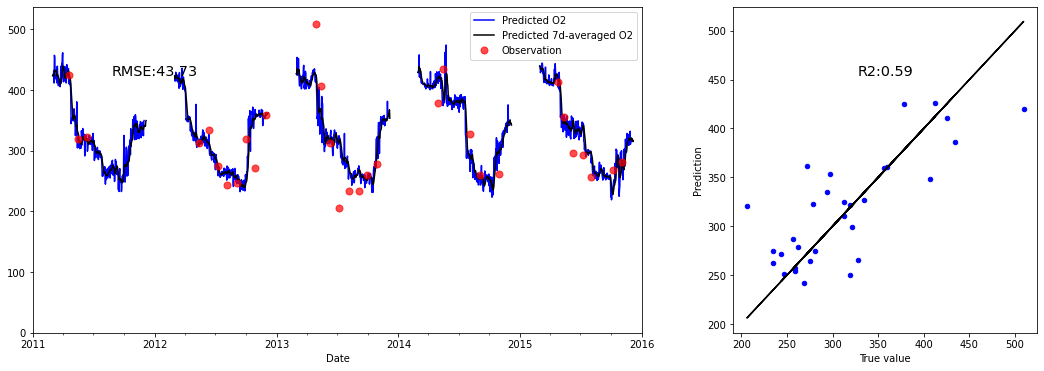

In [475]:
## Predict Nutrient 1
#Lake Erken: ['inflow(m3/s)','AirT','Prec(mm/d)','delT','U','Humidity','CC','swr(w/m2)',
# 'Ice_d','days from iceoff','MLD','W','thermD']
target = input('Target variable:')
model = training_cv(all_df,features,target,year)
ylim = (0,all_df[target].max())
#Erken_test = testing_daily_df[testing_daily_df['Date']>=plot_from]
Lake_Nut,f2 = predict(testing_daily_df,all_df,features,target,test_time,ylim)
os.chdir('..\\Scenario2\\GBR')
fig_name = input('Name of figure:')
f2.savefig(fig_name+'.png',dpi = 500)

['U', 'AirT', 'delT', 'inflow', 'outflow', 'swr', 'W', 'MLD', 'Ice_d', 'days_from_iceoff', 'O2']
Add extra features:
Target variable:N_Nit
Training dataset evaluation:
RMSE 13.94 (+/- 5.77)
R2 0.61 (+/- 0.18)
Name of figure:ME_GBR_N_Nit


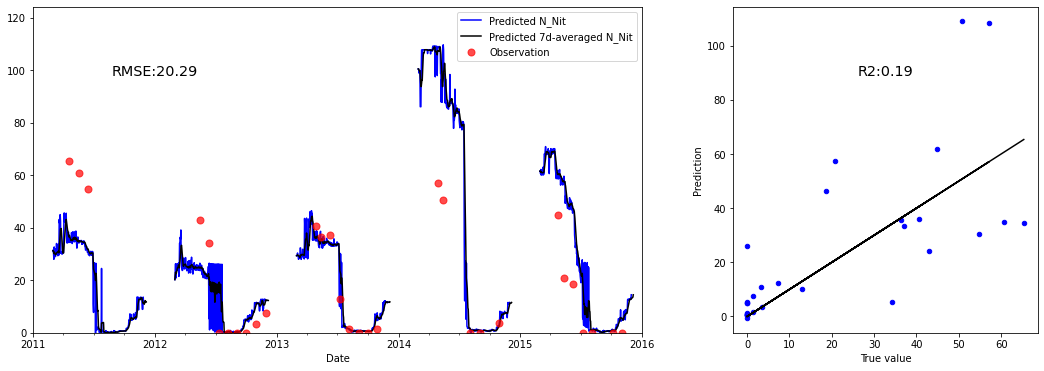

In [479]:
## Predict Nutrient 2
print(features)
while True:
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
target = input('Target variable:')
model = training_cv(all_df,features,target,year)
ylim = (0,all_df[target].max())
Lake_Nut,f2= predict(Lake_Nut,all_df,features,target,test_time,ylim)
fig_name = input('Name of figure:')
f2.savefig(fig_name+'.png',dpi = 500)

['U', 'AirT', 'delT', 'inflow', 'outflow', 'swr', 'W', 'MLD', 'Ice_d', 'days_from_iceoff', 'O2']
Add extra features:N_Nit
Add extra features:
Target variable:N_Amm
Training dataset evaluation:
RMSE 2.85 (+/- 0.69)
R2 0.77 (+/- 0.14)
Name of figure:ME_GBR_N_Amm


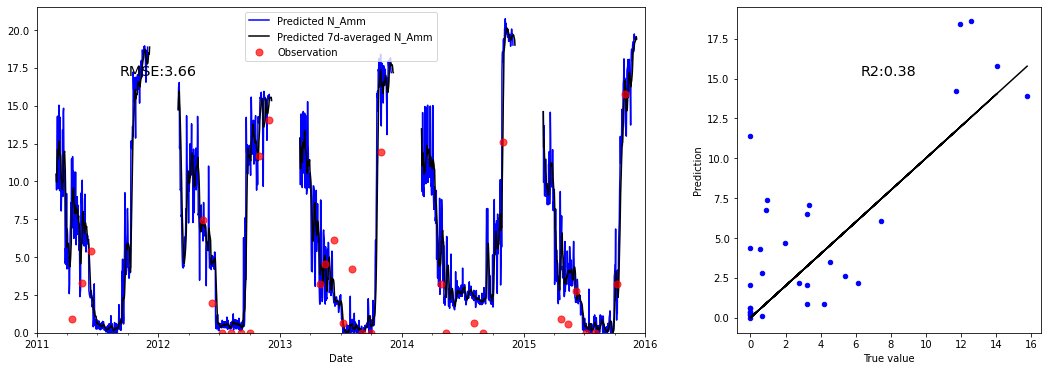

In [480]:
## Predict Nutrient 3
print(features)
while True:
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
# Lake Erken:['inflow(m3/s)','AirT','Prec(mm/d)','delT','U','Humidity','CC','swr(w/m2)',
#            'Ice_d','days from iceoff','MLD','W','thermD',
#            'NOX(mmole/m3)','O2(mmole/m3)']

target = input('Target variable:')
model = training_cv(all_df,features,target,year)
ylim = (0,all_df[target].max())
Lake_Nut,f2= predict(Lake_Nut,all_df,features,target,test_time,ylim)
fig_name = input('Name of figure:')
f2.savefig(fig_name+'.png',dpi = 500)

['U', 'AirT', 'delT', 'inflow', 'outflow', 'swr', 'W', 'MLD', 'Ice_d', 'days_from_iceoff', 'O2', 'N_Nit']
Add extra features:N_Amm
Add extra features:
Target variable:PO4
Training dataset evaluation:
RMSE 0.71 (+/- 0.15)
R2 0.74 (+/- 0.11)
Name of figure:ME_GBR_PO4


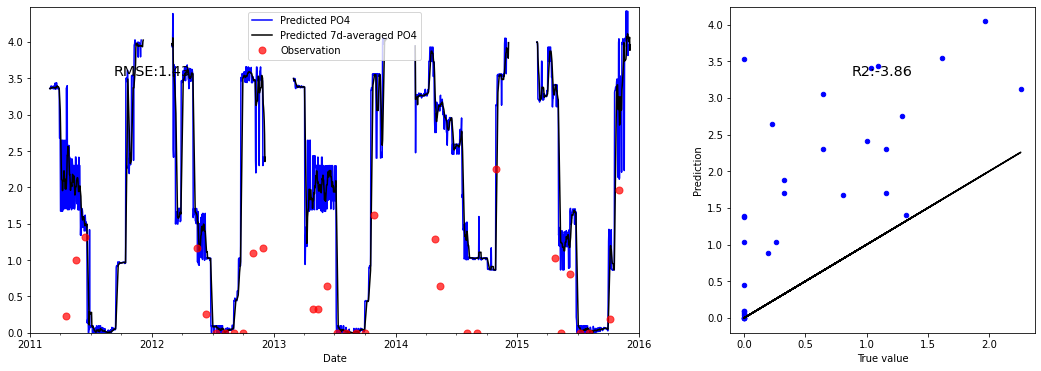

In [481]:
## Predict Nutrient 4
print(features)
while True:
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
# Lake Erken:['inflow(m3/s)','AirT','Prec(mm/d)','delT','U','Humidity','CC','swr(w/m2)',
#            'Ice_d','days from iceoff','MLD','W','thermD',
#            'NOX(mmole/m3)','O2(mmole/m3)']
target = input('Target variable:')
model = training_cv(all_df,features,target,year)
ylim = (0,all_df[target].max())
Lake_Nut,f2  = predict(Lake_Nut,all_df,features,target,test_time,ylim)
fig_name = input('Name of figure:')
f2.savefig(fig_name+'.png',dpi = 500)

['U', 'AirT', 'delT', 'inflow', 'outflow', 'swr', 'W', 'MLD', 'Ice_d', 'days_from_iceoff', 'O2', 'N_Nit', 'N_Amm']
Add extra features:PO4
Add extra features:
Target variable:Si
Training dataset evaluation:
RMSE 45.69 (+/- 4.19)
R2 -1.64 (+/- 1.94)
Name of figure:ME_GBR_Si


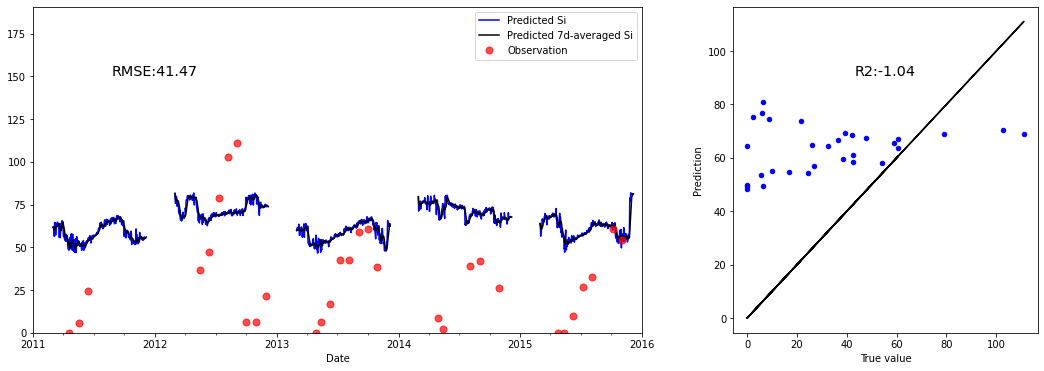

In [482]:
## Predict Nutrient 5
print(features)
while True:
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
target = input('Target variable:')
ylim = (0,all_df[target].max())
model = training_cv(all_df,features,target,year)
Lake_Nut,f2 = predict(Lake_Nut,all_df,features,target,test_time,ylim)
fig_name = input('Name of figure:')
f2.savefig(fig_name+'.png',dpi = 500)

['U', 'AirT', 'delT', 'inflow', 'outflow', 'swr', 'W', 'MLD', 'Ice_d', 'days_from_iceoff', 'O2', 'N_Nit', 'N_Amm', 'PO4']
Add extra features:Si
Add extra features:
Target variable:CAR_dic
Training dataset evaluation:
RMSE 427.24 (+/- 272.34)
R2 -0.08 (+/- 0.44)
Name of figure:ME_GBR_CAR_dic


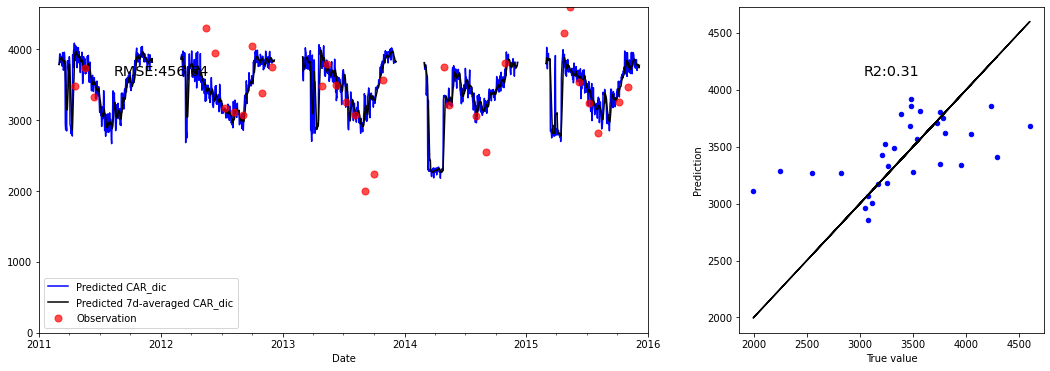

In [483]:
## Predict Nutrient 6
print(features)
while True:
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
target = input('Target variable:')
ylim = (0,all_df[target].max())
model = training_cv(all_df,features,target,year)
Lake_Nut,f2 = predict(Lake_Nut,all_df,features,target,test_time,ylim)
fig_name = input('Name of figure:')
f2.savefig(fig_name+'.png',dpi = 500)

['U', 'AirT', 'delT', 'inflow', 'outflow', 'swr', 'W', 'MLD', 'Ice_d', 'days_from_iceoff', 'O2', 'N_Nit', 'N_Amm', 'PO4', 'Si', 'CAR_dic']
Add extra features:
Target variable:Chl
Training dataset evaluation:
RMSE 5.88 (+/- 1.71)
R2 0.03 (+/- 0.54)
Name of figure:ME_GBR_Chl


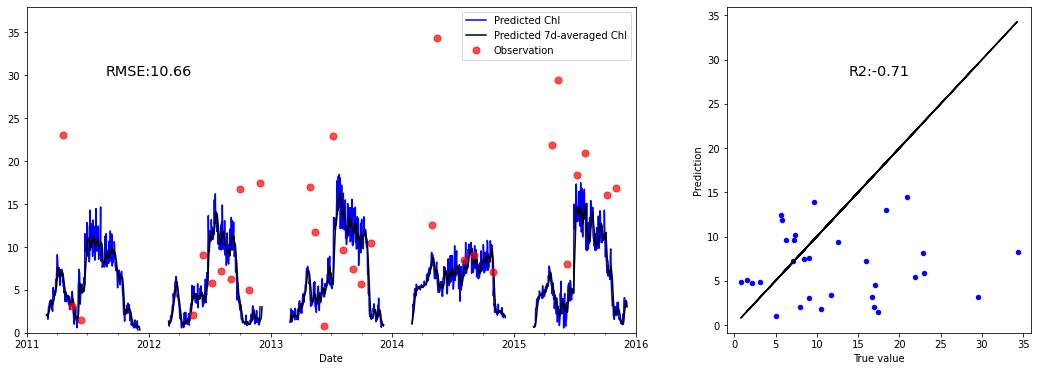

In [485]:
## Predict Chl via the same GBR method as the one used to pre-generate nutrients
print(features)
while True:
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
target = input('Target variable:')
model = training_cv(all_df,features,target,year)
ylim = (0,all_df[target].max())
Lake_Nut,f2 = predict(Lake_Nut,all_df,features,target,test_time,ylim)
fig_name = input('Name of figure:')
f2.savefig(fig_name+'.png',dpi = 500)

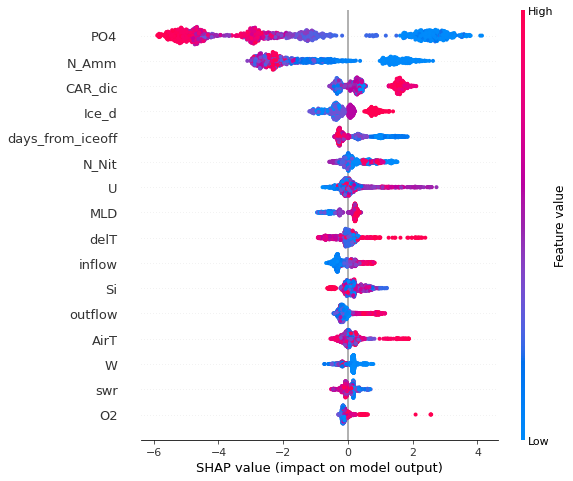

In [486]:
GBR = pickle.load(open('GBR.Chl.dat','rb'))
shap_values = shap.TreeExplainer(GBR).shap_values(Lake_Nut[features])
shap.summary_plot(shap_values,Lake_Nut[features],show=False)
plt.savefig('ME_Feature ranking.png')

In [487]:
Lake_Nut.to_csv('ME_GBR predicted nutrient and Chl.csv',index = False)

# LSTM model

In [488]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers import Dropout

In [489]:
# Load daily dataset
def read_daily_df(features,file): # test_time = pd.Timestamp(yyyy,mm,dd)
    Lake_HydMet = pd.read_csv(file,header = 0,parse_dates = ['Date'])
    return Lake_HydMet

In [490]:
# convert series to supervised learning
def series_to_supervised(data, n_in, n_out, var_name,dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1] # number of variables
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(var_name[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(var_name[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(var_name[j]+'(t+%d)' % (i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg

In [491]:
# load dataset
def load_dataset(df,var_name):
    values = df[var_name].values
    return values

In [492]:
# reframe dataset
def reframe(values,hyperparameters,var_name):
    reframed = series_to_supervised(values, hyperparameters['time_steps'], hyperparameters['n_out'],var_name)
    reframed = reframed.iloc[hyperparameters['time_steps']:]
    drop_col =[]
    n_var = len(var_name)
    for i in range(1,hyperparameters['time_steps']+1):
        drop_col += [n_var*i-1]
    
    reframed.drop(reframed.iloc[:,drop_col],axis=1,inplace = True)
    return reframed

In [493]:
def sparse_dataset(data_X,data_y):
    index = []
    y = []
    for i in range(len(data_y)):
        if ~np.isnan(data_y[i]):
            index.append(i)
            y.append(data_y[i])
    X = np.stack(data_X[index,:,:])
    y = np.array(y)
    return index,X,y

In [494]:
def fit_lstm(train_X,train_y,n_batch,nb_epoch,n_neuros,dropout,verbose):
    # design network
    model = Sequential()
    model.add(LSTM(n_neuros,  return_sequences = True,
              input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros, return_sequences = True))
    model.add(Dropout(dropout))
    model.add(LSTM(n_neuros))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_X,train_y,epochs =nb_epoch,batch_size = n_batch,verbose = verbose)
    return model

In [495]:
def plot_comparison(df,y,yhat,yhat_ts,n_date,time_steps,index,rmse,r2,nutrient,test_time,ylim):
    # Observation time
    time = df['Date'].iloc[n_date+time_steps:].reset_index()['Date'].iloc[index] 
    # Direct comparison of observation and prediction [yhat] (data point to data point)
    pred = pd.DataFrame(concatenate((yhat.reshape(yhat.shape[0],1),y.reshape(y.shape[0],1)), axis=1),
                        index = time)
    pred.columns = ['Prediction','True value']
    # Extract the continuous timeseries from input dataset
    time_ts = df['Date'].iloc[n_date+time_steps:]
    # The continuous prediction yhat_ts 
    pred_ts = pd.DataFrame(yhat_ts,index = time_ts,columns = ['Prediction'])
    # Compute the 7d rolling mean of the timeseries predction
    pred_ts['Prediction_7d'] = pred_ts['Prediction'].rolling(7,min_periods = 1).mean()
    # Create a continous timeseries without winter gap
    Date = pd.DataFrame(pd.date_range(start = time_ts.iloc[0],
                                  end = time_ts.iloc[-1]),
                    columns = ['Date'])
    pred_ts_gap = Date.merge(pred_ts,how = 'left',on = 'Date')
    f1,ax1 = plt.subplots(1,2,figsize = (18,6),gridspec_kw={'width_ratios': [2, 1]})
    pred_ts_gap.plot(x = 'Date',y = ['Prediction','Prediction_7d'],
                     style = {'Prediction':'b-','Prediction_7d':'k-'},
                     ax = ax1[0])
    pred.plot(y = 'True value',style='ro',alpha = 0.7,ms = 7,ax = ax1[0])
    ax1[0].set_ylabel(nutrient)
    ax1[0].set_xlim((test_time[0],test_time[1]))
    ax1[0].set_ylim(ylim)
    ax1[0].text(0.7, 0.9, 'RMSE:{}'.format(round(rmse,2)), 
            horizontalalignment='center',verticalalignment='center', 
            transform=ax1[0].transAxes,fontsize='x-large')
    pred.plot(x = 'True value', y = 'Prediction',kind = 'scatter',s = 20,c = 'blue',ax = ax1[1])
    ax1[1].plot(pred['True value'],pred['True value'],lw  =1.5,color = 'black')
    ax1[1].text(0.5, 0.8, 'R2:{}'.format(round(r2,2)), 
                horizontalalignment='center',verticalalignment='center', 
                transform=ax1[1].transAxes,fontsize='x-large')
    return f1

In [496]:
def predict_ts(df,nutrient,model,hyperparameters,values):
    # add the predictive values into dataset
    value_X, value_y = values[:, :-1], values[:, -1]
    value_X = value_X.reshape((value_X.shape[0], hyperparameters['time_steps']+1, int(value_X.shape[1]/(hyperparameters['time_steps']+1))))
    y_pred = Scaler.inverse_transform(model.predict(value_X,batch_size = hyperparameters['n_batch']))    
    df[nutrient].iloc[hyperparameters['time_steps']:]=y_pred[:,0]
    df[nutrient].fillna(method = 'backfill',inplace = True)
    return df

In [497]:
def split_dataset(train,test,time_steps):
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], time_steps+1, int(train_X.shape[1]/(time_steps+1))))
    test_X = test_X.reshape((test_X.shape[0], time_steps+1, int(test_X.shape[1]/(time_steps+1))))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    print('number of input timesteps: {}'.format(train_X.shape[1]))
    print('number of features: {}'.format(train_X.shape[2]))
    return train_X, train_y,test_X, test_y

In [498]:
# ensure all data is float
def predict_lstm(df,values,var_name,nutrient,test_time,hyperparameters,ylim):
    n_date = df[(df['Date']<test_time[0])|(df['Date']>test_time[1])]['Date'].count()
    train = values[:n_date, :]
    test = values[n_date:, :]
    train_X, train_y,test_X, test_y = split_dataset(train,test,hyperparameters['time_steps'])
    # fit the lstm model
    index,X,y = sparse_dataset(train_X,train_y) # stack the timeseries input together to create a 2D training input X, and a 1D lable y
    y_scaled = Scaler.fit_transform(y.reshape(-1,1))
    print('number of samples: {}'.format(len(index)))
    kf = KFold(n_splits=5, shuffle=True, random_state=101) # 5-fold cross validation
    RMSE = []
    R2 = []
    # fit the lstm model 
    for train_index, test_index in kf.split(X,y_scaled):
        #print("TRAIN:", len(train_index), "TEST:", len(test_index))
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_scaled[train_index], y_scaled[test_index]
        model = fit_lstm(X_train,y_train,hyperparameters['n_batch'],hyperparameters['nb_epoch'],
                         hyperparameters['n_neuros'],hyperparameters['dropout'],hyperparameters['verbose'])
        yhat = Scaler.inverse_transform(model.predict(X_test,batch_size = hyperparameters['n_batch']))
        y_test = Scaler.inverse_transform(y_test)
        try:
            rmse = sqrt(mean_squared_error(y_test, yhat))
            r2 =  r2_score(y_test, yhat)
            RMSE.append(rmse) 
            R2.append(r2)
        except ValueError:
            print(X_test)
        #print('Training RMSE: %.2f' %rmse)       
    # make a prediction
    index,X,y = sparse_dataset(test_X,test_y) # index is the time series
    yhat = Scaler.inverse_transform(model.predict(X,batch_size = hyperparameters['n_batch']))
    rmse = sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y, yhat)
    print('Test RMSE: %.2f' % rmse)
    print('Test R2: %.2f' %r2)
    # make a prediction for the whole timeseries
    yhat_ts = Scaler.inverse_transform(model.predict(test_X,batch_size = hyperparameters['n_batch']))
    figure = plot_comparison(df,y,yhat,yhat_ts,n_date,hyperparameters['time_steps'],index,rmse,r2,nutrient,test_time,ylim)
    return model,RMSE,R2,figure

In [499]:
# Go back to trainning data folder
os.chdir('..\\..\\Trainning data')
os.getcwd()

'D:\\PDF_Uppsala\\7-Python code of ML algorithm\\GitHub\\Algal-bloom-prediction-machine-learning\\Trainning data'

In [500]:
# Create the daily df with Nan in nutrients columns
n_Nut = int(input('Number of Lake nutrient features (including Date and target variable):'))
Nut_features = []
for i in range(n_Nut):
    N=input('Nutrient:')
    Nut_features.append(N)
Nut = all_df[Nut_features]
daily_file = input('Name of daily observation datasets:')
test_time = [pd.Timestamp(int(input('Test start in year:')),int(input('Test start in month:')),int(input('Test start on day:'))),
             pd.Timestamp(int(input('Test end in year:')),int(input('Test end in month:')),int(input('Test end in day:')))]

Number of Lake nutrient features (including Date and target variable):8
Nutrient:Date
Nutrient:O2
Nutrient:N_Nit
Nutrient:N_Amm
Nutrient:CAR_dic
Nutrient:Si
Nutrient:PO4
Nutrient:Chl
Name of daily observation datasets:ME_Daily_Observation_df_modified.csv
Test start in year:2011
Test start in month:1
Test start on day:1
Test end in year:2016
Test end in month:1
Test end in day:1


In [501]:
daily_df = read_daily_df(features,file)
Nut_memory = daily_df.merge(Nut,how = 'left',on = 'Date')

In [502]:
# set the directory to LSTM 
os.chdir('..\\Scenario2\\LSTM')
# set the hyperparameters
hyperparameters = {'n_batch':10,'nb_epoch':200,'n_neuros':200,'dropout':0.1,'time_steps':7,'n_out':1,'verbose':0}

In [503]:
# Basic daily features
n_var = int(input('Number of features:'))
var_name = []
for i in range(n_var):
    f = input('variable name:')
    var_name.append(f)

Number of features:10
variable name:U
variable name:AirT
variable name:delT
variable name:swr
variable name:inflow
variable name:outflow
variable name:W
variable name:MLD
variable name:Ice_d
variable name:days_from_iceoff


['U', 'AirT', 'delT', 'swr', 'inflow', 'outflow', 'W', 'MLD', 'Ice_d', 'days_from_iceoff']
Target variable:O2
(8800, 8, 10) (8800,) (1368, 8, 10) (1368,)
number of input timesteps: 8
number of features: 10
number of samples: 70
Test RMSE: 39.48
Test R2: 0.67
Training dataset RMSE 38.05 (+/- 10.19)
Training dataset R2 0.65 (+/- 0.23)
Model takes 5 min to run
Name of figure:ME_LSTM_O2


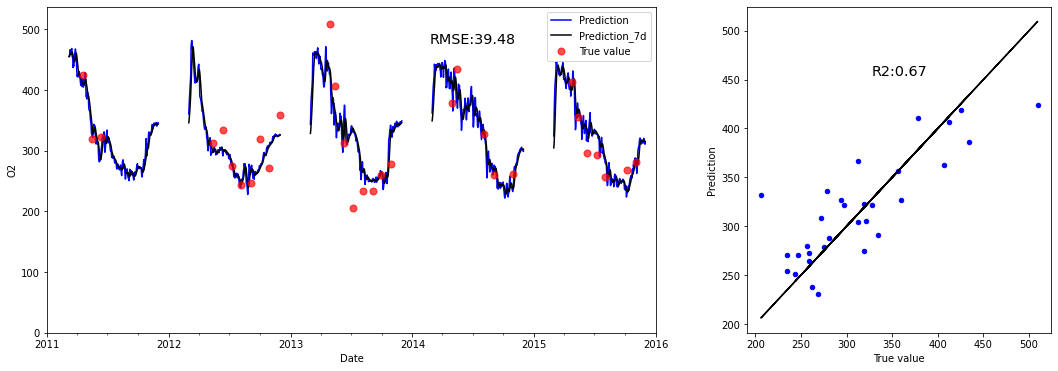

In [504]:
# predict Nutrient 1
print(var_name)
nutrient = input('Target variable:')
var_name.append(nutrient)
values = load_dataset(Nut_memory,var_name) #values = values.astype('float32')
# frame as supervised learning
reframed = reframe(values,hyperparameters,var_name)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,var_name,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
fig_name = input('Name of figure:')
figure.savefig(fig_name+'.png',dpi = 500)

In [505]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,SST,delT,U,AirT,CC,Prec,swr,inflow,outflow,MLD,W,doy,month,Ice_d,days_from_iceoff,MM,O2,N_Nit,N_Amm,CAR_dic,Si,PO4,Chl
0,1979-03-01,0.764389,-2.620929,1.593941,-2.992495,NaN,0.4762,185.210999,7.635921,7.867276,1.548121,0.000000,60,3,93.000000,-46,3,455.393188,NaN,NaN,NaN,NaN,NaN,NaN
1,1979-03-02,0.920434,-2.468256,4.249354,-5.280408,NaN,0.6036,188.470290,7.287510,7.936561,1.501116,0.000000,61,3,93.000000,-45,3,455.393188,NaN,NaN,NaN,NaN,NaN,NaN
2,1979-03-03,0.727219,-2.664457,3.202813,-1.517493,NaN,9.6772,75.183791,8.554949,8.209879,0.650000,0.000000,62,3,93.000000,-44,3,455.393188,NaN,NaN,NaN,NaN,NaN,NaN
3,1979-03-04,0.174805,-3.218732,1.919469,0.616671,NaN,3.0956,109.187751,9.942403,8.346746,0.650000,0.000000,63,3,93.000000,-43,3,455.393188,NaN,NaN,NaN,NaN,NaN,NaN
4,1979-03-05,0.084467,-3.311187,2.815478,-2.330826,NaN,0.0822,84.293958,9.816358,8.669169,0.650000,0.000000,64,3,93.000000,-42,3,455.393188,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,2015-11-26,6.730435,0.778029,3.169159,4.285010,NaN,25.0532,25.239375,16.804982,11.418577,25.000000,0.000000,330,11,100.958333,223,11,320.441833,NaN,NaN,NaN,NaN,NaN,NaN
10171,2015-11-27,6.626987,0.000000,5.685337,2.327086,NaN,12.5068,66.596083,15.235910,13.823858,25.000000,0.000000,331,11,100.958333,224,11,318.196899,NaN,NaN,NaN,NaN,NaN,NaN
10172,2015-11-28,6.360925,1.181410,2.800493,-0.982494,NaN,0.0000,81.125292,17.910961,14.750084,23.150000,1.769155,332,11,100.958333,225,11,311.979980,NaN,NaN,NaN,NaN,NaN,NaN
10173,2015-11-29,6.137963,1.383737,1.984414,-1.319994,NaN,0.0000,42.381708,18.948644,15.256056,21.874141,2.731964,333,11,100.958333,226,11,315.473694,NaN,NaN,NaN,NaN,NaN,NaN


['U', 'AirT', 'delT', 'swr', 'inflow', 'outflow', 'W', 'MLD', 'Ice_d', 'days_from_iceoff', 'O2']
Target variable:N_Nit
Delete any feature?(Y/N)N
Add extra features:
(8800, 8, 11) (8800,) (1368, 8, 11) (1368,)
number of input timesteps: 8
number of features: 11
number of samples: 70
Test RMSE: 18.54
Test R2: 0.33
Training dataset RMSE 14.49 (+/- 5.57)
Training dataset R2 0.64 (+/- 0.10)
Model takes 4 min to run
Name of figure:N_Nit


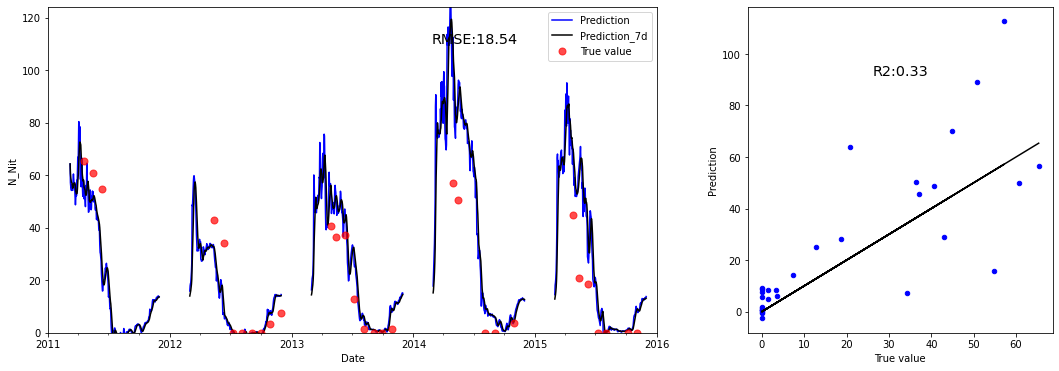

In [506]:
# predict Nutrient 2
print(var_name)
nutrient = input('Target variable:')
while True:
    Del_var = input('Delete any feature?(Y/N)')
    if Del_var =='Y':
        var_name.pop()
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
var_name.append(nutrient)
values = load_dataset(Nut_memory,var_name) #values = values.astype('float32')
# frame as supervised learning
n_var = len(var_name)
reframed = reframe(values,hyperparameters,var_name)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,var_name,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
fig_name = input('Name of figure:')
figure.savefig(fig_name+'.png',dpi = 500)

In [507]:
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,SST,delT,U,AirT,CC,Prec,swr,inflow,outflow,MLD,W,doy,month,Ice_d,days_from_iceoff,MM,O2,N_Nit,N_Amm,CAR_dic,Si,PO4,Chl
0,1979-03-01,0.764389,-2.620929,1.593941,-2.992495,NaN,0.4762,185.210999,7.635921,7.867276,1.548121,0.000000,60,3,93.000000,-46,3,455.393188,50.542187,NaN,NaN,NaN,NaN,NaN
1,1979-03-02,0.920434,-2.468256,4.249354,-5.280408,NaN,0.6036,188.470290,7.287510,7.936561,1.501116,0.000000,61,3,93.000000,-45,3,455.393188,50.542187,NaN,NaN,NaN,NaN,NaN
2,1979-03-03,0.727219,-2.664457,3.202813,-1.517493,NaN,9.6772,75.183791,8.554949,8.209879,0.650000,0.000000,62,3,93.000000,-44,3,455.393188,50.542187,NaN,NaN,NaN,NaN,NaN
3,1979-03-04,0.174805,-3.218732,1.919469,0.616671,NaN,3.0956,109.187751,9.942403,8.346746,0.650000,0.000000,63,3,93.000000,-43,3,455.393188,50.542187,NaN,NaN,NaN,NaN,NaN
4,1979-03-05,0.084467,-3.311187,2.815478,-2.330826,NaN,0.0822,84.293958,9.816358,8.669169,0.650000,0.000000,64,3,93.000000,-42,3,455.393188,50.542187,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,2015-11-26,6.730435,0.778029,3.169159,4.285010,NaN,25.0532,25.239375,16.804982,11.418577,25.000000,0.000000,330,11,100.958333,223,11,320.441833,13.322227,NaN,NaN,NaN,NaN,NaN
10171,2015-11-27,6.626987,0.000000,5.685337,2.327086,NaN,12.5068,66.596083,15.235910,13.823858,25.000000,0.000000,331,11,100.958333,224,11,318.196899,13.414556,NaN,NaN,NaN,NaN,NaN
10172,2015-11-28,6.360925,1.181410,2.800493,-0.982494,NaN,0.0000,81.125292,17.910961,14.750084,23.150000,1.769155,332,11,100.958333,225,11,311.979980,13.133994,NaN,NaN,NaN,NaN,NaN
10173,2015-11-29,6.137963,1.383737,1.984414,-1.319994,NaN,0.0000,42.381708,18.948644,15.256056,21.874141,2.731964,333,11,100.958333,226,11,315.473694,13.436672,NaN,NaN,NaN,NaN,NaN


['U', 'AirT', 'delT', 'swr', 'inflow', 'outflow', 'W', 'MLD', 'Ice_d', 'days_from_iceoff', 'O2', 'N_Nit']
Target variable:N_Amm
Delete any feature?(Y/N)N
Add extra features:
(8800, 8, 12) (8800,) (1368, 8, 12) (1368,)
number of input timesteps: 8
number of features: 12
number of samples: 70
Test RMSE: 2.90
Test R2: 0.61
Training dataset RMSE 3.07 (+/- 0.90)
Training dataset R2 0.73 (+/- 0.18)
Model takes 4 min to run
Name of figure:ME_LSTM_N_Amm


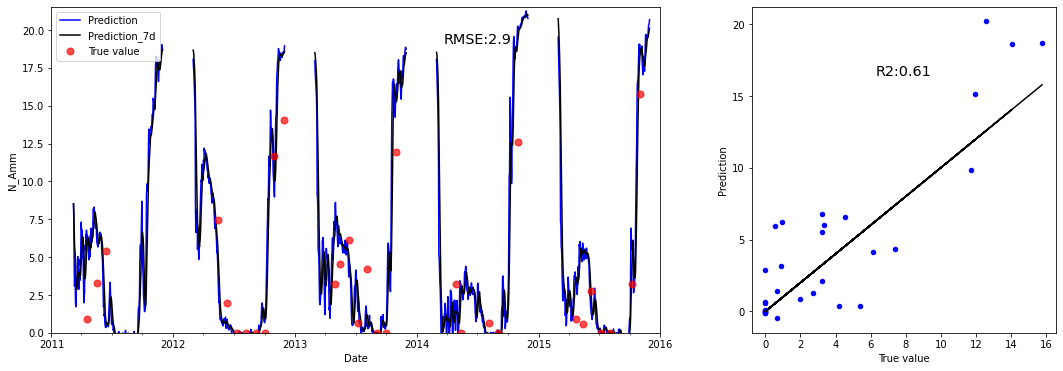

In [508]:
#predict Nutrient 3
print(var_name)
nutrient = input('Target variable:')
while True:
    Del_var = input('Delete any feature?(Y/N)')
    if Del_var =='Y':
        var_name.pop()
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
var_name.append(nutrient)
values = load_dataset(Nut_memory,var_name) #values = values.astype('float32')
# frame as supervised learning
n_var = len(var_name)
reframed = reframe(values,hyperparameters,var_name)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,var_name,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
fig_name = input('Name of figure:')
figure.savefig(fig_name+'.png',dpi = 500)

In [509]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,SST,delT,U,AirT,CC,Prec,swr,inflow,outflow,MLD,W,doy,month,Ice_d,days_from_iceoff,MM,O2,N_Nit,N_Amm,CAR_dic,Si,PO4,Chl
0,1979-03-01,0.764389,-2.620929,1.593941,-2.992495,NaN,0.4762,185.210999,7.635921,7.867276,1.548121,0.000000,60,3,93.000000,-46,3,455.393188,50.542187,3.034982,NaN,NaN,NaN,NaN
1,1979-03-02,0.920434,-2.468256,4.249354,-5.280408,NaN,0.6036,188.470290,7.287510,7.936561,1.501116,0.000000,61,3,93.000000,-45,3,455.393188,50.542187,3.034982,NaN,NaN,NaN,NaN
2,1979-03-03,0.727219,-2.664457,3.202813,-1.517493,NaN,9.6772,75.183791,8.554949,8.209879,0.650000,0.000000,62,3,93.000000,-44,3,455.393188,50.542187,3.034982,NaN,NaN,NaN,NaN
3,1979-03-04,0.174805,-3.218732,1.919469,0.616671,NaN,3.0956,109.187751,9.942403,8.346746,0.650000,0.000000,63,3,93.000000,-43,3,455.393188,50.542187,3.034982,NaN,NaN,NaN,NaN
4,1979-03-05,0.084467,-3.311187,2.815478,-2.330826,NaN,0.0822,84.293958,9.816358,8.669169,0.650000,0.000000,64,3,93.000000,-42,3,455.393188,50.542187,3.034982,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,2015-11-26,6.730435,0.778029,3.169159,4.285010,NaN,25.0532,25.239375,16.804982,11.418577,25.000000,0.000000,330,11,100.958333,223,11,320.441833,13.322227,19.945309,NaN,NaN,NaN,NaN
10171,2015-11-27,6.626987,0.000000,5.685337,2.327086,NaN,12.5068,66.596083,15.235910,13.823858,25.000000,0.000000,331,11,100.958333,224,11,318.196899,13.414556,20.303177,NaN,NaN,NaN,NaN
10172,2015-11-28,6.360925,1.181410,2.800493,-0.982494,NaN,0.0000,81.125292,17.910961,14.750084,23.150000,1.769155,332,11,100.958333,225,11,311.979980,13.133994,20.352940,NaN,NaN,NaN,NaN
10173,2015-11-29,6.137963,1.383737,1.984414,-1.319994,NaN,0.0000,42.381708,18.948644,15.256056,21.874141,2.731964,333,11,100.958333,226,11,315.473694,13.436672,20.442787,NaN,NaN,NaN,NaN


['U', 'AirT', 'delT', 'swr', 'inflow', 'outflow', 'W', 'MLD', 'Ice_d', 'days_from_iceoff', 'O2', 'N_Nit', 'N_Amm']
Target variable:PO4
Delete any feature?(Y/N)N
Add extra features:
(8800, 8, 13) (8800,) (1368, 8, 13) (1368,)
number of input timesteps: 8
number of features: 13
number of samples: 70
Test RMSE: 1.22
Test R2: -2.51
Training dataset RMSE 0.68 (+/- 0.13)
Training dataset R2 0.77 (+/- 0.08)
Model takes 4 min to run
Name of figure:ME_LSTM_PO4


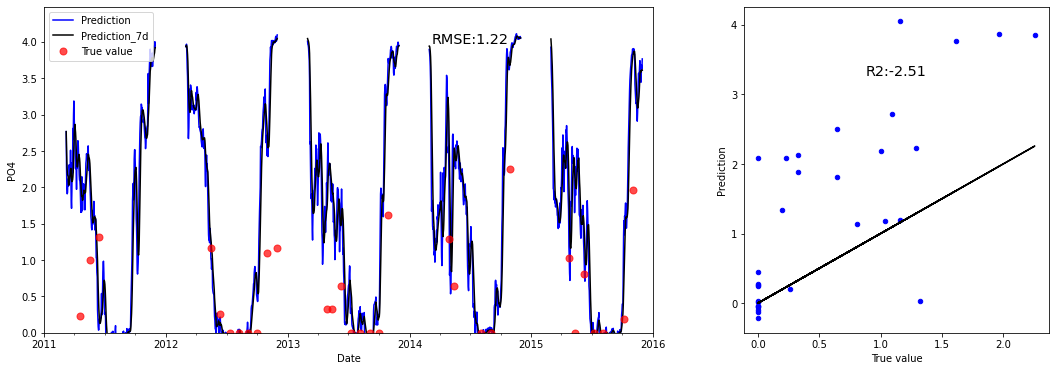

In [510]:
# Predict Nutrient 4
print(var_name)
nutrient = input('Target variable:')
while True:
    Del_var = input('Delete any feature?(Y/N)')
    while Del_var =='Y':
        var_name.pop()
        Del_var = input('Delete any feature?(Y/N)')
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
var_name.append(nutrient)
values = load_dataset(Nut_memory,var_name) #values = values.astype('float32')
# frame as supervised learning
n_var = len(var_name)
reframed = reframe(values,hyperparameters,var_name)
values = reframed.values
ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,var_name,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
fig_name = input('Name of figure:')
figure.savefig(fig_name+'.png',dpi = 500)

In [512]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,SST,delT,U,AirT,CC,Prec,swr,inflow,outflow,MLD,W,doy,month,Ice_d,days_from_iceoff,MM,O2,N_Nit,N_Amm,CAR_dic,Si,PO4,Chl
0,1979-03-01,0.764389,-2.620929,1.593941,-2.992495,NaN,0.4762,185.210999,7.635921,7.867276,1.548121,0.000000,60,3,93.000000,-46,3,455.393188,50.542187,3.034982,NaN,NaN,1.244541,NaN
1,1979-03-02,0.920434,-2.468256,4.249354,-5.280408,NaN,0.6036,188.470290,7.287510,7.936561,1.501116,0.000000,61,3,93.000000,-45,3,455.393188,50.542187,3.034982,NaN,NaN,1.244541,NaN
2,1979-03-03,0.727219,-2.664457,3.202813,-1.517493,NaN,9.6772,75.183791,8.554949,8.209879,0.650000,0.000000,62,3,93.000000,-44,3,455.393188,50.542187,3.034982,NaN,NaN,1.244541,NaN
3,1979-03-04,0.174805,-3.218732,1.919469,0.616671,NaN,3.0956,109.187751,9.942403,8.346746,0.650000,0.000000,63,3,93.000000,-43,3,455.393188,50.542187,3.034982,NaN,NaN,1.244541,NaN
4,1979-03-05,0.084467,-3.311187,2.815478,-2.330826,NaN,0.0822,84.293958,9.816358,8.669169,0.650000,0.000000,64,3,93.000000,-42,3,455.393188,50.542187,3.034982,NaN,NaN,1.244541,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,2015-11-26,6.730435,0.778029,3.169159,4.285010,NaN,25.0532,25.239375,16.804982,11.418577,25.000000,0.000000,330,11,100.958333,223,11,320.441833,13.322227,19.945309,NaN,NaN,3.444046,NaN
10171,2015-11-27,6.626987,0.000000,5.685337,2.327086,NaN,12.5068,66.596083,15.235910,13.823858,25.000000,0.000000,331,11,100.958333,224,11,318.196899,13.414556,20.303177,NaN,NaN,3.571815,NaN
10172,2015-11-28,6.360925,1.181410,2.800493,-0.982494,NaN,0.0000,81.125292,17.910961,14.750084,23.150000,1.769155,332,11,100.958333,225,11,311.979980,13.133994,20.352940,NaN,NaN,3.680007,NaN
10173,2015-11-29,6.137963,1.383737,1.984414,-1.319994,NaN,0.0000,42.381708,18.948644,15.256056,21.874141,2.731964,333,11,100.958333,226,11,315.473694,13.436672,20.442787,NaN,NaN,3.630439,NaN


['U', 'AirT', 'delT', 'swr', 'inflow', 'outflow', 'W', 'MLD', 'Ice_d', 'days_from_iceoff', 'O2', 'N_Nit', 'N_Amm', 'PO4']
Target variable:Si
Delete any feature?(Y/N)N
Add extra features:
(8800, 8, 14) (8800,) (1368, 8, 14) (1368,)
number of input timesteps: 8
number of features: 14
number of samples: 70
Test RMSE: 38.82
Test R2: -0.79
Training dataset RMSE 47.65 (+/- 7.96)
Training dataset R2 -0.40 (+/- 0.41)
Model takes 4 min to run
Name of figure:ME_LSTM_Si


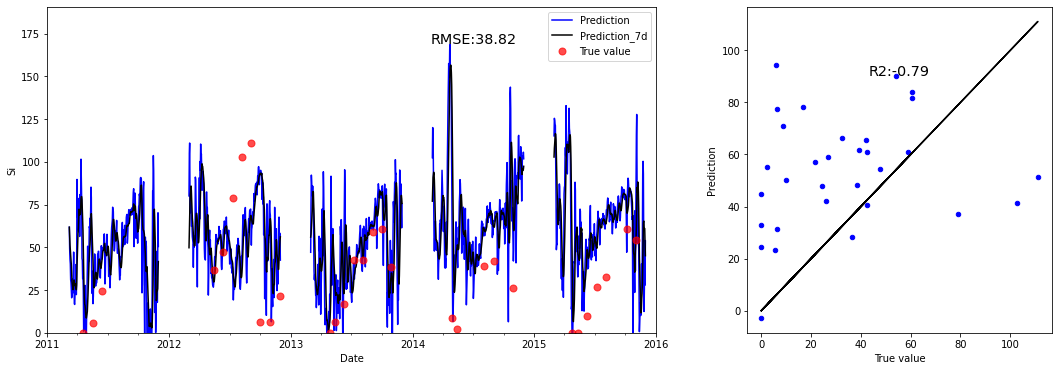

In [513]:
# Predict Nutrient 5
print(var_name)
nutrient = input('Target variable:')
while True:
    Del_var = input('Delete any feature?(Y/N)')
    while Del_var =='Y':
        var_name.pop()
        Del_var = input('Delete any feature?(Y/N)')
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
var_name.append(nutrient)
values = load_dataset(Nut_memory,var_name) #values = values.astype('float32')
# frame as supervised learning
n_var = len(var_name)
reframed = reframe(values,hyperparameters,var_name)
values = reframed.values

ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,var_name,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
fig_name = input('Name of figure:')
figure.savefig(fig_name+'.png',dpi = 500)

In [514]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,SST,delT,U,AirT,CC,Prec,swr,inflow,outflow,MLD,W,doy,month,Ice_d,days_from_iceoff,MM,O2,N_Nit,N_Amm,CAR_dic,Si,PO4,Chl
0,1979-03-01,0.764389,-2.620929,1.593941,-2.992495,NaN,0.4762,185.210999,7.635921,7.867276,1.548121,0.000000,60,3,93.000000,-46,3,455.393188,50.542187,3.034982,NaN,12.889730,1.244541,NaN
1,1979-03-02,0.920434,-2.468256,4.249354,-5.280408,NaN,0.6036,188.470290,7.287510,7.936561,1.501116,0.000000,61,3,93.000000,-45,3,455.393188,50.542187,3.034982,NaN,12.889730,1.244541,NaN
2,1979-03-03,0.727219,-2.664457,3.202813,-1.517493,NaN,9.6772,75.183791,8.554949,8.209879,0.650000,0.000000,62,3,93.000000,-44,3,455.393188,50.542187,3.034982,NaN,12.889730,1.244541,NaN
3,1979-03-04,0.174805,-3.218732,1.919469,0.616671,NaN,3.0956,109.187751,9.942403,8.346746,0.650000,0.000000,63,3,93.000000,-43,3,455.393188,50.542187,3.034982,NaN,12.889730,1.244541,NaN
4,1979-03-05,0.084467,-3.311187,2.815478,-2.330826,NaN,0.0822,84.293958,9.816358,8.669169,0.650000,0.000000,64,3,93.000000,-42,3,455.393188,50.542187,3.034982,NaN,12.889730,1.244541,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,2015-11-26,6.730435,0.778029,3.169159,4.285010,NaN,25.0532,25.239375,16.804982,11.418577,25.000000,0.000000,330,11,100.958333,223,11,320.441833,13.322227,19.945309,NaN,12.457669,3.444046,NaN
10171,2015-11-27,6.626987,0.000000,5.685337,2.327086,NaN,12.5068,66.596083,15.235910,13.823858,25.000000,0.000000,331,11,100.958333,224,11,318.196899,13.414556,20.303177,NaN,25.765104,3.571815,NaN
10172,2015-11-28,6.360925,1.181410,2.800493,-0.982494,NaN,0.0000,81.125292,17.910961,14.750084,23.150000,1.769155,332,11,100.958333,225,11,311.979980,13.133994,20.352940,NaN,53.985855,3.680007,NaN
10173,2015-11-29,6.137963,1.383737,1.984414,-1.319994,NaN,0.0000,42.381708,18.948644,15.256056,21.874141,2.731964,333,11,100.958333,226,11,315.473694,13.436672,20.442787,NaN,27.879223,3.630439,NaN


['U', 'AirT', 'delT', 'swr', 'inflow', 'outflow', 'W', 'MLD', 'Ice_d', 'days_from_iceoff', 'O2', 'N_Nit', 'N_Amm', 'PO4', 'Si']
Target variable:CAR_dic
Delete any feature?(Y/N)N
Add extra features:
(8800, 8, 15) (8800,) (1368, 8, 15) (1368,)
number of input timesteps: 8
number of features: 15
number of samples: 70
Test RMSE: 565.27
Test R2: -0.06
Training dataset RMSE 535.19 (+/- 259.92)
Training dataset R2 -0.68 (+/- 0.98)
Model takes 4 min to run
Name of figure:ME_LSTM_CAR_dic


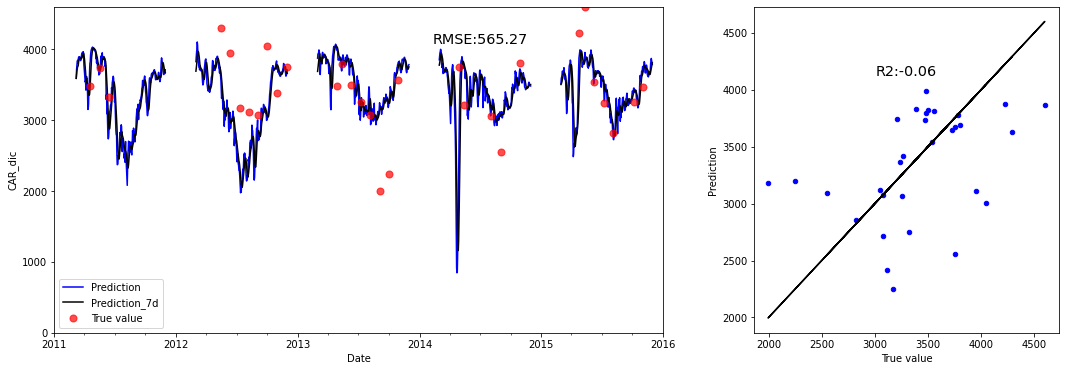

In [515]:
# Predict Nutrient 6
print(var_name)
nutrient = input('Target variable:')
while True:
    Del_var = input('Delete any feature?(Y/N)')
    while Del_var =='Y':
        var_name.pop()
        Del_var = input('Delete any feature?(Y/N)')
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
var_name.append(nutrient)
values = load_dataset(Nut_memory,var_name) #values = values.astype('float32')
# frame as supervised learning
n_var = len(var_name)
reframed = reframe(values,hyperparameters,var_name)
values = reframed.values
ylim = (0,all_df[nutrient].max())
start_time = time.time()
Nut_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,var_name,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
fig_name = input('Name of figure:')
figure.savefig(fig_name+'.png',dpi = 500)

In [516]:
# use the trained model to interplate the whole timeseries
Nut_memory = predict_ts(Nut_memory,nutrient,Nut_model,hyperparameters,values)
Nut_memory


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,SST,delT,U,AirT,CC,Prec,swr,inflow,outflow,MLD,W,doy,month,Ice_d,days_from_iceoff,MM,O2,N_Nit,N_Amm,CAR_dic,Si,PO4,Chl
0,1979-03-01,0.764389,-2.620929,1.593941,-2.992495,NaN,0.4762,185.210999,7.635921,7.867276,1.548121,0.000000,60,3,93.000000,-46,3,455.393188,50.542187,3.034982,3916.740723,12.889730,1.244541,NaN
1,1979-03-02,0.920434,-2.468256,4.249354,-5.280408,NaN,0.6036,188.470290,7.287510,7.936561,1.501116,0.000000,61,3,93.000000,-45,3,455.393188,50.542187,3.034982,3916.740723,12.889730,1.244541,NaN
2,1979-03-03,0.727219,-2.664457,3.202813,-1.517493,NaN,9.6772,75.183791,8.554949,8.209879,0.650000,0.000000,62,3,93.000000,-44,3,455.393188,50.542187,3.034982,3916.740723,12.889730,1.244541,NaN
3,1979-03-04,0.174805,-3.218732,1.919469,0.616671,NaN,3.0956,109.187751,9.942403,8.346746,0.650000,0.000000,63,3,93.000000,-43,3,455.393188,50.542187,3.034982,3916.740723,12.889730,1.244541,NaN
4,1979-03-05,0.084467,-3.311187,2.815478,-2.330826,NaN,0.0822,84.293958,9.816358,8.669169,0.650000,0.000000,64,3,93.000000,-42,3,455.393188,50.542187,3.034982,3916.740723,12.889730,1.244541,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,2015-11-26,6.730435,0.778029,3.169159,4.285010,NaN,25.0532,25.239375,16.804982,11.418577,25.000000,0.000000,330,11,100.958333,223,11,320.441833,13.322227,19.945309,3837.648682,12.457669,3.444046,NaN
10171,2015-11-27,6.626987,0.000000,5.685337,2.327086,NaN,12.5068,66.596083,15.235910,13.823858,25.000000,0.000000,331,11,100.958333,224,11,318.196899,13.414556,20.303177,3870.370605,25.765104,3.571815,NaN
10172,2015-11-28,6.360925,1.181410,2.800493,-0.982494,NaN,0.0000,81.125292,17.910961,14.750084,23.150000,1.769155,332,11,100.958333,225,11,311.979980,13.133994,20.352940,3838.840820,53.985855,3.680007,NaN
10173,2015-11-29,6.137963,1.383737,1.984414,-1.319994,NaN,0.0000,42.381708,18.948644,15.256056,21.874141,2.731964,333,11,100.958333,226,11,315.473694,13.436672,20.442787,3820.014160,27.879223,3.630439,NaN


['U', 'AirT', 'delT', 'swr', 'inflow', 'outflow', 'W', 'MLD', 'Ice_d', 'days_from_iceoff', 'O2', 'N_Nit', 'N_Amm', 'PO4', 'Si', 'CAR_dic']
Target variable:Chl
Delete any feature?(Y/N)N
Add extra features:
(8800, 8, 16) (8800,) (1368, 8, 16) (1368,)
number of input timesteps: 8
number of features: 16
number of samples: 70
Test RMSE: 11.17
Test R2: -0.87
Training dataset RMSE 7.39 (+/- 1.58)
Training dataset R2 -0.11 (+/- 0.37)
Model takes 4 min to run
Name of figure:ME_LSTM_Chl


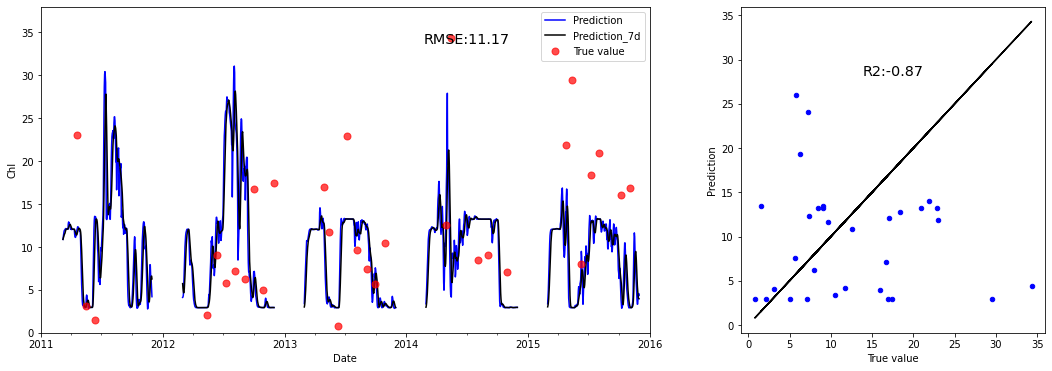

In [517]:
# Predict Chl
print(var_name)
nutrient = input('Target variable:')
while True:
    Del_var = input('Delete any feature?(Y/N)')
    while Del_var =='Y':
        var_name.pop()
        Del_var = input('Delete any feature?(Y/N)')
    add_features = input('Add extra features:')
    if add_features:
        features.append(add_features)
    else:
        break
var_name.append(nutrient)
values = load_dataset(Nut_memory,var_name) #values = values.astype('float32')
# frame as supervised learning
n_var = len(var_name)
reframed = reframe(values,hyperparameters,var_name)
values = reframed.values
ylim = (0,all_df[nutrient].max())
start_time = time.time()
Chl_model,RMSE,R2,figure = predict_lstm(Nut_memory,values,var_name,nutrient,test_time,hyperparameters,ylim)
# 5-fold cross validation was used to estimate the model performance
print("Training dataset RMSE %.2f (+/- %.2f)" % (np.mean(RMSE), np.std(RMSE)))
print("Training dataset R2 %.2f (+/- %.2f)" % (np.mean(R2), np.std(R2)))
print('Model takes '+str(round((time.time()-start_time)/60))+' min to run')
fig_name = input('Name of figure:')
figure.savefig(fig_name+'.png',dpi = 500)

In [411]:
# use the trained model to interplate the whole timeseriestime_steps,n_out,verbose
Nut_memory = predict_ts(Nut_memory,nutrient,Chl_model,hyperparameters,values)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [412]:
Nut_memory.to_csv('ME_LSTM predicted nutrient and Chl data.csv',index = False)